In [2]:
pip install numpy pandas matplotlib scikit-learn tensorflow imbalanced-learn joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install ipywidgets

Data loaded. Initial shape: (14988, 14)


C:\Users\cam71\AppData\Local\Temp\ipykernel_24080\717527911.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["SEASON"] = season_encoder.fit_transform(df["SEASON"])


Best RandomForest params: {'max_depth': 10, 'n_estimators': 200}
Best GradientBoosting params: {'learning_rate': 0.1, 'n_estimators': 100}
Best LogisticRegression params: {'C': 0.1, 'solver': 'liblinear'}
Training model with best RF params...
Model saved to wildfire_model.joblib

--- RandomForest Evaluation ---
Confusion Matrix:
 [[2544  458]
 [ 501  990]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84      3002
           1       0.68      0.66      0.67      1491

    accuracy                           0.79      4493
   macro avg       0.76      0.76      0.76      4493
weighted avg       0.79      0.79      0.79      4493

ROC AUC Score: 0.8393695506371562

--- GradientBoosting Evaluation ---
Confusion Matrix:
 [[2528  474]
 [ 509  982]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      3002
           1       0.67      0.66     

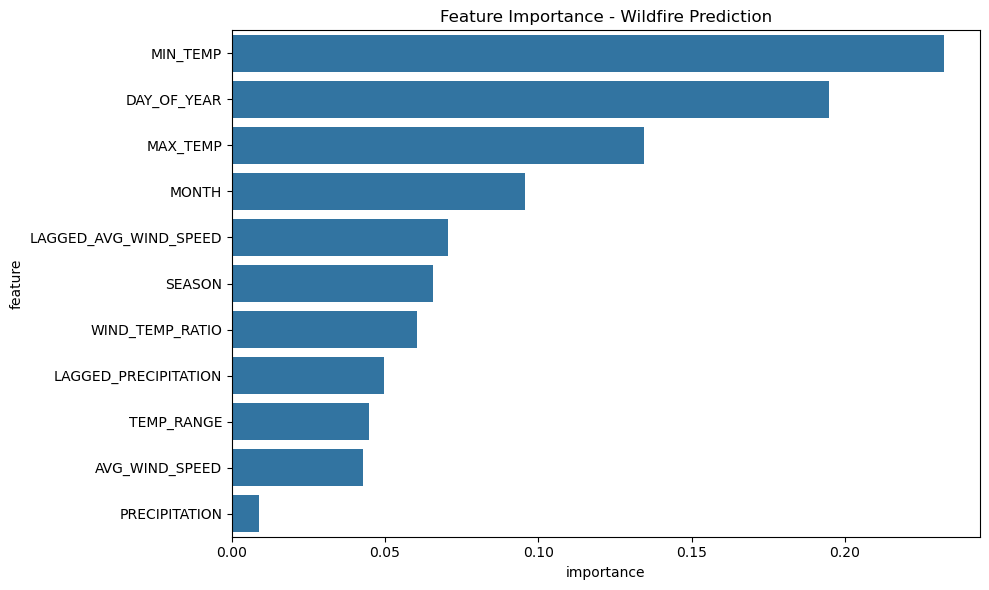

C:\Users\cam71\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\cam71\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training FeedforwardNN
Epoch 1/20


C:\Users\cam71\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


328/328 - 5s - 15ms/step - accuracy: 0.7402 - auc: 0.7852 - loss: 0.5206 - val_accuracy: 0.7723 - val_auc: 0.8253 - val_loss: 0.4758
Epoch 2/20
328/328 - 2s - 5ms/step - accuracy: 0.7681 - auc: 0.8200 - loss: 0.4831 - val_accuracy: 0.7754 - val_auc: 0.8286 - val_loss: 0.4731
Epoch 3/20
328/328 - 2s - 5ms/step - accuracy: 0.7689 - auc: 0.8243 - loss: 0.4778 - val_accuracy: 0.7748 - val_auc: 0.8297 - val_loss: 0.4712
Epoch 4/20
328/328 - 2s - 5ms/step - accuracy: 0.7710 - auc: 0.8244 - loss: 0.4767 - val_accuracy: 0.7736 - val_auc: 0.8327 - val_loss: 0.4706
Epoch 5/20
328/328 - 3s - 8ms/step - accuracy: 0.7712 - auc: 0.8260 - loss: 0.4766 - val_accuracy: 0.7728 - val_auc: 0.8326 - val_loss: 0.4682
Epoch 6/20
328/328 - 1s - 4ms/step - accuracy: 0.7712 - auc: 0.8269 - loss: 0.4747 - val_accuracy: 0.7734 - val_auc: 0.8333 - val_loss: 0.4697
Epoch 7/20
328/328 - 1s - 4ms/step - accuracy: 0.7688 - auc: 0.8294 - loss: 0.4719 - val_accuracy: 0.7748 - val_auc: 0.8342 - val_loss: 0.4663
Epoch 8/2

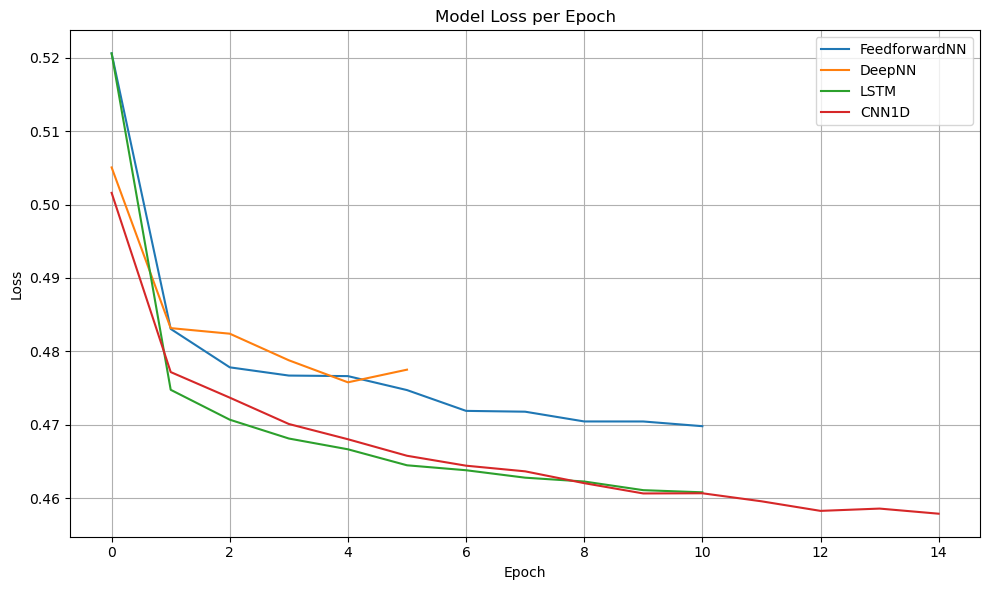

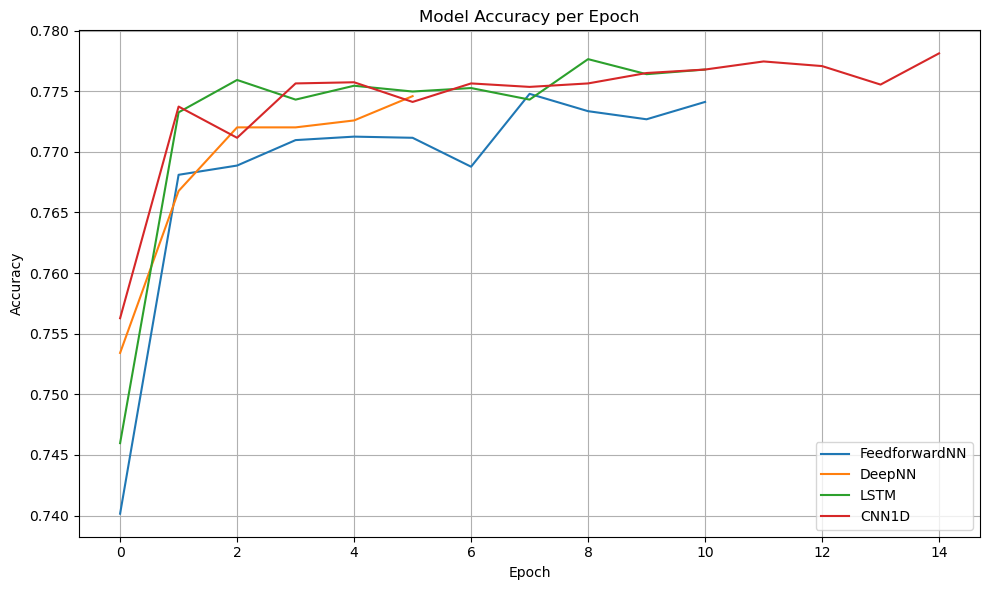

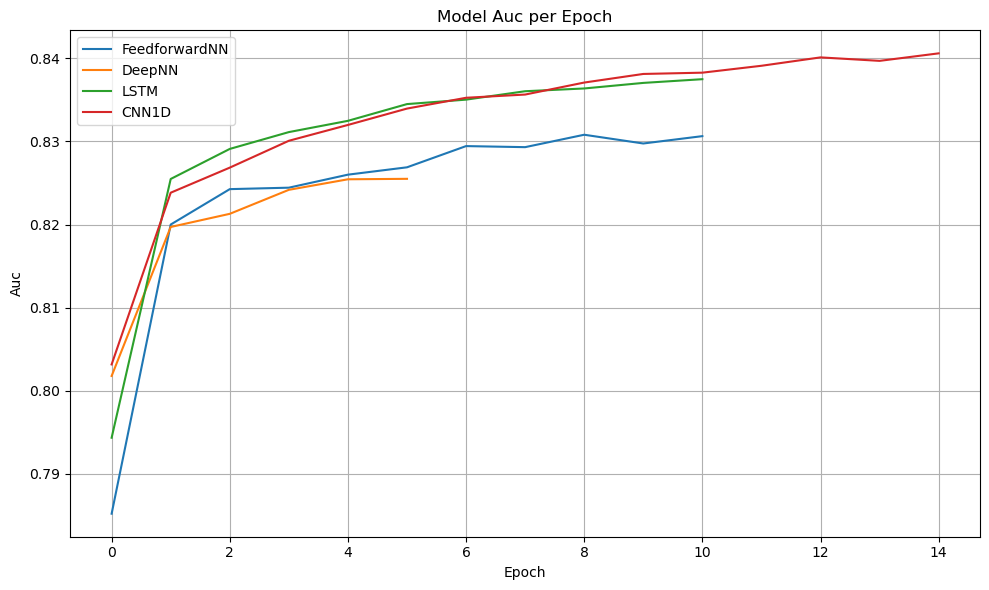

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import ipywidgets as widgets
from IPython.display import display, clear_output

def load_data(filepath):
    df = pd.read_csv(filepath, parse_dates=["DATE"])
    print(f"Data loaded. Initial shape: {df.shape}")
    return df

def preprocess_data(df):
    df = df.dropna()
    season_encoder = LabelEncoder()
    df["SEASON"] = season_encoder.fit_transform(df["SEASON"])
    return df, season_encoder

def get_features_and_labels(df):
    features = [
        "PRECIPITATION", "MAX_TEMP", "MIN_TEMP", "AVG_WIND_SPEED",
        "TEMP_RANGE", "WIND_TEMP_RATIO", "MONTH", "SEASON",
        "LAGGED_PRECIPITATION", "LAGGED_AVG_WIND_SPEED", "DAY_OF_YEAR"
    ]
    X = df[features]
    y = df["FIRE_START_DAY"].astype(int)
    return X, y, features

def split_data(X, y, test_size=0.3, random_state=50):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def hyperparameter_tuning(X_train, y_train):
    param_grids = {
        "RandomForest": {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20]
        },
        "GradientBoosting": {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1]
        },
        "LogisticRegression": {
            'C': [0.1, 1.0, 10.0],
            'solver': ['liblinear']
        }
    }
    best_models = {}

    rf = RandomForestClassifier(random_state=50)
    gs_rf = GridSearchCV(rf, param_grids["RandomForest"], cv=3, scoring='roc_auc')
    gs_rf.fit(X_train, y_train)
    print("Best RandomForest params:", gs_rf.best_params_)
    best_models["RandomForest"] = gs_rf.best_estimator_

    gb = GradientBoostingClassifier(random_state=50)
    gs_gb = GridSearchCV(gb, param_grids["GradientBoosting"], cv=3, scoring='roc_auc')
    gs_gb.fit(X_train, y_train)
    print("Best GradientBoosting params:", gs_gb.best_params_)
    best_models["GradientBoosting"] = gs_gb.best_estimator_

    lr = LogisticRegression(max_iter=1000, random_state=50)
    gs_lr = GridSearchCV(lr, param_grids["LogisticRegression"], cv=3, scoring='roc_auc')
    gs_lr.fit(X_train, y_train)
    print("Best LogisticRegression params:", gs_lr.best_params_)
    best_models["LogisticRegression"] = gs_lr.best_estimator_

    return best_models

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

def evaluate_all_models(models, X_test, y_test):
    for name, model in models.items():
        print(f"\n--- {name} Evaluation ---")
        evaluate_model(model, X_test, y_test)

def plot_feature_importance(model, features):
    importances = model.feature_importances_
    feature_df = pd.DataFrame({"feature": features, "importance": importances})
    feature_df = feature_df.sort_values("importance", ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_df, x="importance", y="feature")
    plt.title("Feature Importance - Wildfire Prediction")
    plt.tight_layout()
    plt.show()

def save_model(model, filename="wildfire_model.joblib"):
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

def load_model(filename="wildfire_model.joblib"):
    model = joblib.load(filename)
    print(f"Model loaded from {filename}")
    return model

def build_deep_learning_models(input_dim):
    models = {}
    model_ff = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_ff.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['FeedforwardNN'] = model_ff

    model_deep = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_deep.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['DeepNN'] = model_deep

    model_lstm = Sequential([
        LSTM(32, input_shape=(1, input_dim), return_sequences=False),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['LSTM'] = model_lstm

    model_cnn = Sequential([
        Conv1D(32, 1, activation='relu', input_shape=(1, input_dim)),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    models['CNN1D'] = model_cnn

    return models

if __name__ == "__main__":
    df = load_data("wildfire_dataset.csv")
    df, season_encoder = preprocess_data(df)
    X, y, features = get_features_and_labels(df)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = split_data(X_scaled, y)

    best_models = hyperparameter_tuning(X_train, y_train)

    try:
        model = load_model()
    except FileNotFoundError:
        print("Training model with best RF params...")
        model = best_models["RandomForest"]
        model.fit(X_train, y_train)
        save_model(model)

    evaluate_all_models(best_models, X_test, y_test)
    plot_feature_importance(best_models["RandomForest"], features)

    deep_models = build_deep_learning_models(X_train.shape[1])
    X_train_seq = X_train.reshape(-1, 1, X_train.shape[1])
    X_test_seq = X_test.reshape(-1, 1, X_test.shape[1])

    history_dict = {}

    for name, dl_model in deep_models.items():
        print(f"Training {name}")
        if name in ['LSTM', 'CNN1D']:
            history = dl_model.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test),
                         epochs=20, batch_size=32, callbacks=[EarlyStopping(patience=3)], verbose=2)
            results = dl_model.evaluate(X_test_seq, y_test)
        else:
            history = dl_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                         epochs=20, batch_size=32, callbacks=[EarlyStopping(patience=3)], verbose=2)
            results = dl_model.evaluate(X_test, y_test)
        history_dict[name] = history
        print(f"{name} - Test Loss: {results[0]}, Test Accuracy: {results[1]}, Test AUC: {results[2]}")

    # Plot comparison of DL metrics
    metrics = ['loss', 'accuracy', 'auc']
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        for name, history in history_dict.items():
            if metric in history.history:
                plt.plot(history.history[metric], label=f'{name}')
        plt.title(f'Model {metric.capitalize()} per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [3]:
joblib.dump(model, "wildfire_model.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(season_encoder, "season_encoder.joblib")

['season_encoder.joblib']